In [115]:
"""
This notebook generates the main figures for the paper.
"""

import re
import warnings
warnings.showwarning = lambda m, *a, **k: print(re.sub(r"/Users/[^/]+/", "/Users/USER/", str(m)))

import pickle
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots

import matplotlib.cm as cm

# Plot styling
plt.style.use("science")
sns.set_context("poster", font_scale=1.0)

In [117]:
# Load Bootstrap Results

def load_bootstrap_results(results_dir):
    """Load trained bootstrap models and associated data.
    
    Args:
        results_dir: Path to directory containing bootstrap results.
    
    Returns:
        Dictionary containing:
            - models: List of trained LitTTS models
            - config: TIMEVIEW Config object
            - X: DataFrame of patient covariates
            - ts: List of time point arrays
            - ys: List of tumor volume arrays
            - metadata: Dictionary of run parameters
    """
    results_path = Path(results_dir)
    
    # Load models
    with open(results_path / "bootstrap_models.pkl", "rb") as f:
        models = pickle.load(f)
    
    # Load config
    with open(results_path / "config.pkl", "rb") as f:
        config = pickle.load(f)
    
    # Load dataset
    with open(results_path / "dataset.pkl", "rb") as f:
        X, ts, ys = pickle.load(f)
    
    # Load metadata
    with open(results_path / "metadata.json", "r") as f:
        import json
        metadata = json.load(f)
    
    return {
        "models": models,
        "config": config,
        "X": X,
        "ts": ts,
        "ys": ys,
        "metadata": metadata
    }


def get_ensemble_predictions(models, feature_vector, time_grid):
    """Get trajectory predictions from all bootstrap models.
    
    Args:
        models: List of trained LitTTS models.
        feature_vector: numpy array of patient covariates.
        time_grid: numpy array of time points for prediction.
    
    Returns:
        Dictionary containing:
            - trajectories: Array of shape (n_models, n_timepoints)
            - mean: Mean trajectory across models
            - std: Standard deviation across models
            - p05: 5th percentile trajectory
            - p95: 95th percentile trajectory
    """
    trajectories = []
    
    for model in models:
        y_pred = model.model.forecast_trajectory(
            np.asarray(feature_vector, dtype=float), 
            time_grid
        )
        trajectories.append(np.asarray(y_pred, dtype=float))
    
    trajectories = np.stack(trajectories, axis=0)
    
    return {
        "trajectories": trajectories,
        "mean": trajectories.mean(axis=0),
        "median": np.median(trajectories, axis=0),
        "std": trajectories.std(axis=0),
        "p05": np.quantile(trajectories, 0.05, axis=0),
        "p95": np.quantile(trajectories, 0.95, axis=0)
    }


# Load results
RESULTS_DIR = "../outputs_uncertainty"
results = load_bootstrap_results(RESULTS_DIR)

models = results["models"]
config = results["config"]
X = results["X"]
ts = results["ts"]
ys = results["ys"]

print(f"Loaded {len(models)} bootstrap models")
print(f"Dataset: {len(X)} patients")
print(f"Time horizon: {config.T}")

# Create time grid for smooth predictions
T_GRID_POINTS = 200
t_grid = np.linspace(0.0, config.T, T_GRID_POINTS)

# Define patient zero (can be modified)
patient_zero_idx = 0
patient_zero = X.iloc[patient_zero_idx]
patient_zero_features = patient_zero.values

print("\nPatient Zero features:")
for feature_name, value in patient_zero.items():
    print(f"  {feature_name}: {value:.2f}")

Loaded 30 bootstrap models
Dataset: 2000 patients
Time horizon: 1.0

Patient Zero features:
  age: 58.22
  weight: 98.64
  initial_tumor_volume: 0.34
  dosage: 0.66


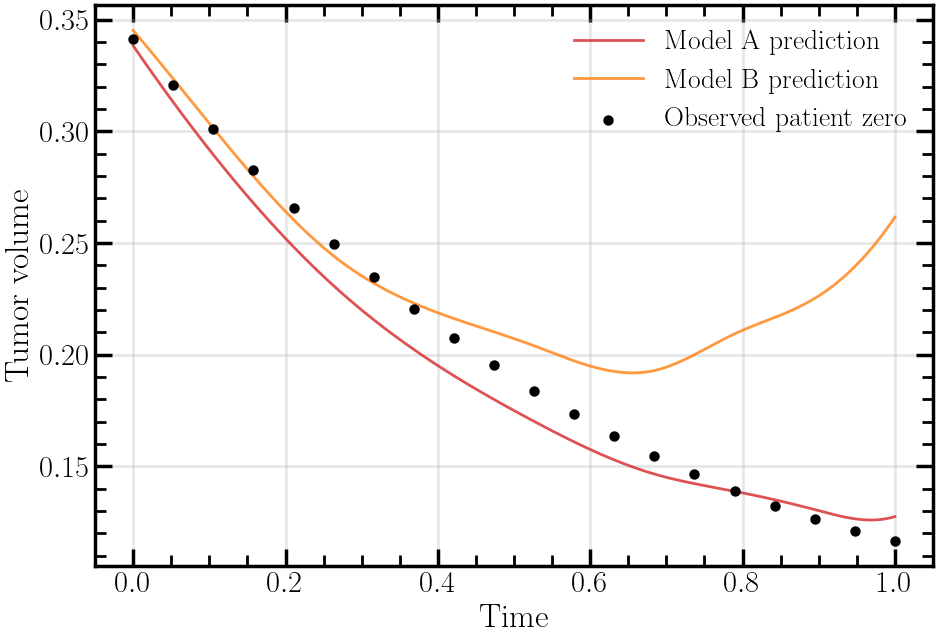

In [121]:
# Figure 1: Qualitatively Different Predictions

def plot_qualitative_differences(models, patient_features, t_obs, y_obs, 
                                 t_grid, model_indices=[27, 29]):
    """Plot trajectory predictions from two models.
    
    Args:
        models: List of bootstrap models.
        patient_features: numpy array of patient covariates.
        t_obs: Observed time points for ground truth.
        y_obs: Observed tumor volumes for ground truth.
        t_grid: Time grid for predictions.
        model_indices: List of two model indices to compare.
    
    Returns:
        Tuple of (fig, ax) matplotlib objects.
    """
    fig, ax = plt.subplots(figsize=(10, 7))
    
    # Get predictions from selected models
    predictions = get_ensemble_predictions(models, patient_features, t_grid)
    trajectories = predictions["trajectories"]
    
    # Plot two contrasting models
    model_a_idx, model_b_idx = model_indices
    ax.plot(t_grid, trajectories[model_a_idx], 
            alpha=0.8, lw=2, color="tab:red", label="Model A prediction")
    ax.plot(t_grid, trajectories[model_b_idx], 
            alpha=0.8, lw=2, color="tab:orange", label="Model B prediction")
    
    # Plot observed data
    ax.scatter(t_obs, y_obs, s=30, zorder=5, 
              label="Observed patient zero", color="black")
    
    ax.set_xlabel("Time")
    ax.set_ylabel("Tumor volume")
    ax.legend(ncol=1, fontsize=20, handlelength=2.5)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig, ax


# Generate Figure 1
fig1, ax1 = plot_qualitative_differences(
    models=models,
    patient_features=patient_zero_features,
    t_obs=ts[patient_zero_idx],
    y_obs=ys[patient_zero_idx],
    t_grid=t_grid,
    model_indices=[27, 29]
)

plt.show()

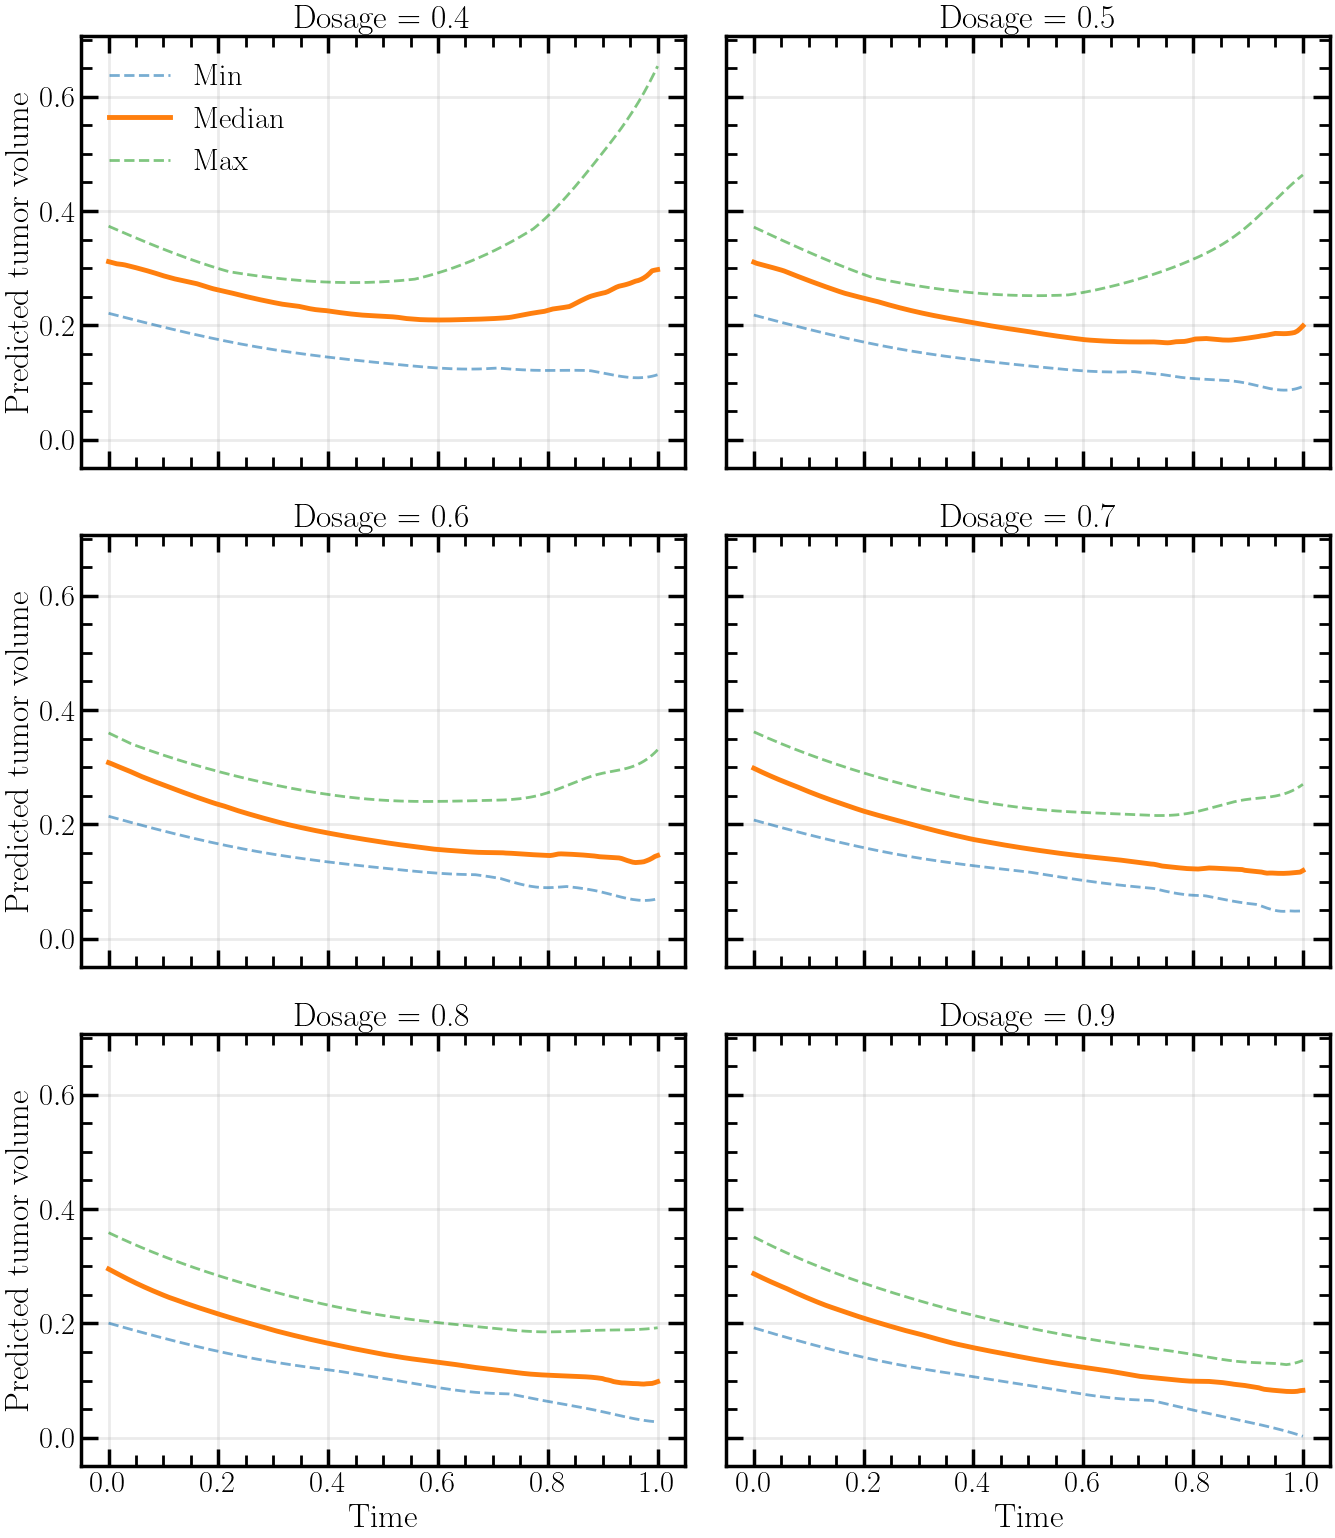

In [122]:
# Figure 2: Dosage Sweep (3x2 Grid)

def plot_dosage_sweep_grid(models, base_features, dosage_values, t_grid):
    """Plot ensemble predictions across different drug dosages in a grid.
    
    Args:
        models: List of bootstrap models.
        base_features: numpy array of baseline patient features (age, weight, tumor vol).
        dosage_values: List of dosage values to sweep over.
        t_grid: Time grid for predictions.
    
    Returns:
        Tuple of (fig, axes, predictions_cache) where predictions_cache
        is a dictionary mapping dosage -> prediction results.
    """
    n_dosages = len(dosage_values)
    n_rows = 3
    n_cols = 2
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 16), 
                            sharex=True, sharey=True)
    axes = axes.flatten()
    
    # Compute predictions for all dosages
    predictions_cache = {}
    all_ymins = []
    all_ymaxs = []
    
    for dosage in dosage_values:
        # Create feature vector with this dosage
        feature_vector = np.concatenate([base_features[:3], [dosage]])
        
        # Get predictions
        preds = get_ensemble_predictions(models, feature_vector, t_grid)
        predictions_cache[dosage] = preds
        
        # Track y-limits for consistent scaling
        all_ymins.append(np.min(preds["trajectories"]))
        all_ymaxs.append(np.max(preds["trajectories"]))
    
    # Set global y-limits
    ymin_global = float(np.min(all_ymins))
    ymax_global = float(np.max(all_ymaxs))
    ypad = 0.08 * (ymax_global - ymin_global + 1e-9)
    
    # Plot each dosage in its subplot
    for i, dosage in enumerate(dosage_values):
        ax = axes[i]
        preds = predictions_cache[dosage]
        
        # Plot min trajectory (dashed, light)
        ax.plot(t_grid, preds["trajectories"].min(axis=0), 
               alpha=0.6, linewidth=2, linestyle="--", 
               color="tab:blue", label="Min")
        
        # Plot median trajectory (solid, thick)
        median = np.median(preds["trajectories"], axis=0)
        ax.plot(t_grid, median, linewidth=3.5, 
            color="tab:orange", label="Median")
        
        # Plot max trajectory (dashed, light)
        ax.plot(t_grid, preds["trajectories"].max(axis=0), 
               alpha=0.6, linewidth=2, linestyle="--", 
               color="tab:green", label="Max")
        
        ax.set_title(f"Dosage = {dosage:.1f}")
        ax.grid(True, alpha=0.25)
        ax.set_ylim(ymin_global - ypad, ymax_global + ypad)
        
        # Labels for edge subplots only
        if i % 2 == 0:
            ax.set_ylabel("Predicted tumor volume")
        if i >= 4:
            ax.set_xlabel("Time")
    
    # Add legend to first panel
    axes[0].legend(loc="best")
    
    plt.tight_layout()
    return fig, axes, predictions_cache


# Generate Figure 2
dosage_values = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
base_features = patient_zero_features[:3]  # age, weight, initial tumor volume

fig2, axes2, dosage_predictions = plot_dosage_sweep_grid(
    models=models,
    base_features=base_features,
    dosage_values=dosage_values,
    t_grid=t_grid
)

plt.show()

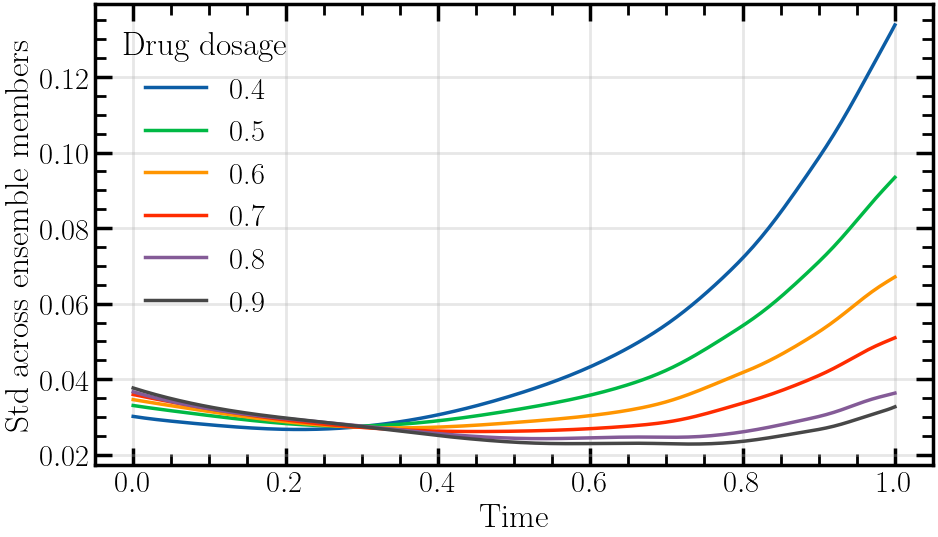

In [123]:
# Figure 3: Uncertainty Over Time by Dosage

def plot_uncertainty_vs_time(predictions_cache, dosage_values, t_grid):
    """Plot how epistemic uncertainty evolves over time for different dosages.

    Args:
        predictions_cache: Dictionary mapping dosage to prediction results.
        dosage_values: List of dosage values.
        t_grid: Time grid for predictions.
    
    Returns:
        Tuple of (fig, ax) matplotlib objects.
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for dosage in dosage_values:
        std = predictions_cache[dosage]["std"]
        ax.plot(t_grid, std, linewidth=2.5, label=f"{dosage:.1f}")
    
    ax.set_xlabel("Time")
    ax.set_ylabel("Std across ensemble members")
    ax.legend(title="Drug dosage", loc="best")
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig, ax


# Generate Figure 3
fig3, ax3 = plot_uncertainty_vs_time(
    predictions_cache=dosage_predictions,
    dosage_values=dosage_values,
    t_grid=t_grid
)

plt.show()

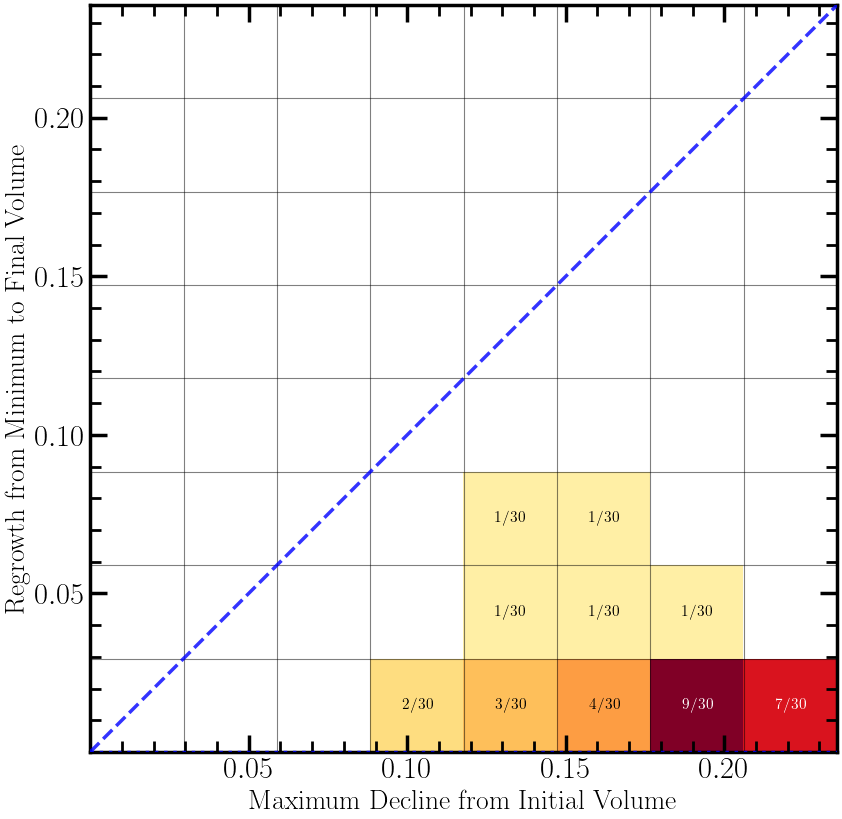

In [124]:
# Trajectory Behavior Heatmap

from collections import Counter
from timeview.basis import BSplineBasis
import numpy as np
import matplotlib.patches as mpatches

def characterize_trajectory_behavior(trajectories, t_grid):
    """Characterize each trajectory by its decline and regrowth behavior.
    
    Args:
        trajectories: Array of shape (n_models, n_timepoints).
        t_grid: Time grid corresponding to trajectories.
    
    Returns:
        Tuple of (max_decline, final_regrowth) arrays, each of length n_models.
            - max_decline: Maximum decrease from initial value (positive = decline)
            - final_regrowth: Increase from minimum to final value (positive = regrowth)
    """
    n_models = trajectories.shape[0]
    max_decline = np.zeros(n_models)
    final_regrowth = np.zeros(n_models)
    
    for i in range(n_models):
        traj = trajectories[i]
        initial = traj[0]
        minimum = traj.min()
        final = traj[-1]
        
        # Maximum decline from initial (how much it decreased)
        max_decline[i] = initial - minimum
        
        # Regrowth from minimum to final (how much it grew back)
        final_regrowth[i] = final - minimum
    
    return max_decline, final_regrowth


def plot_trajectory_behavior_heatmap(models, feature_vector, t_grid, 
                                     patient_label="Patient Zero"):
    """Plot 2D histogram showing decline vs regrowth behavior with fractions.
    
    Args:
        models: List of bootstrap models.
        feature_vector: numpy array of patient covariates.
        t_grid: Time grid for predictions.
        patient_label: String label for the patient.
    
    Returns:
        Tuple of (fig, ax, max_decline, final_regrowth).
    """
    # Get all predictions
    predictions = get_ensemble_predictions(models, feature_vector, t_grid)
    trajectories = predictions["trajectories"]
    
    # Characterize each trajectory
    max_decline, final_regrowth = characterize_trajectory_behavior(trajectories, t_grid)
    
    # Create square bins
    fig, ax = plt.subplots(figsize=(11, 9))
    
    # Determine square extent
    max_val = max(max_decline.max(), final_regrowth.max())
    
    # Reduced number of bins
    n_bins = 8
    
    # Create histogram with square extent
    h, xedges, yedges = np.histogram2d(
        max_decline, final_regrowth, 
        bins=n_bins,
        range=[[0, max_val], [0, max_val]]
    )
    
    # Convert counts to probabilities (percentages) for coloring
    h_prob = (h / len(models)) * 100
    
    # Mask zero probabilities to show as white
    h_prob_masked = np.ma.masked_where(h_prob == 0, h_prob)
    
    # Plot heatmap
    im = ax.imshow(h_prob_masked.T, origin='lower', cmap='YlOrRd',
                   extent=[0, max_val, 0, max_val],
                   aspect='equal', interpolation='nearest',
                   vmin=0, vmax=h_prob.max())
    
    # Set background color to white for masked (empty) cells
    ax.set_facecolor('white')
    
    # Add grid lines between cells
    for edge in xedges:
        ax.axvline(edge, color='black', linewidth=0.8, alpha=0.5)
    for edge in yedges:
        ax.axhline(edge, color='black', linewidth=0.8, alpha=0.5)
    
    # Add fraction text in each cell
    total_models = len(models)
    for i in range(n_bins):
        for j in range(n_bins):
            count = int(h[i, j])
            if count > 0:  # Only show non-zero counts
                x_center = (xedges[i] + xedges[i+1]) / 2
                y_center = (yedges[j] + yedges[j+1]) / 2
                
                # Choose text color based on background intensity
                prob = h_prob[i, j]
                text_color = 'white' if prob > h_prob.max() * 0.5 else 'black'
                
                ax.text(x_center, y_center, f'{count}/{total_models}',
                       ha='center', va='center',
                       fontsize=11, fontweight='bold',
                       color=text_color)
    
    # Add reference lines
    # Horizontal line at y=0 (monotonic decline)
    ax.axhline(y=0, color='blue', linestyle=':', linewidth=2.5, alpha=0.8, zorder=3)
    
    # Diagonal line (returns to initial)
    ax.plot([0, max_val], [0, max_val], 'b--', linewidth=2.5, alpha=0.8, zorder=3)
    
    
    # Labels and formatting
    ax.set_xlabel('Maximum Decline from Initial Volume', fontsize=20)
    ax.set_ylabel('Regrowth from Minimum to Final Volume', fontsize=20)
    ax.grid(False)
    
    # Set square axis limits
    ax.set_xlim(0, max_val)
    ax.set_ylim(0, max_val)
    
    # Remove zeros from axis at origin and 0.25 from top
    xticks = ax.get_xticks()
    yticks = ax.get_yticks()
    ax.set_xticks(xticks[(xticks > 0) & (xticks < max_val)])
    ax.set_yticks(yticks[(yticks > 0) & (yticks < max_val)])
    
    # Use manual layout adjustment instead of tight_layout
    plt.subplots_adjust(left=0.12, right=0.95, top=0.93, bottom=0.10)
    
    return fig, ax, max_decline, final_regrowth


# Generate heatmap for Patient Zero
fig_heat, ax_heat, decline_vals, regrowth_vals = plot_trajectory_behavior_heatmap(
    models=models,
    feature_vector=patient_zero_features,
    t_grid=t_grid,
    patient_label="Patient Zero"
)

plt.show()

In [128]:
# Interactive Ensemble Plot with Heatmap (2-Panel)

from ipywidgets import FloatSlider, HBox, VBox, Label, Output, Layout, Checkbox
from IPython.display import display


def create_feature_sliders(feature_names, feature_ranges, default_values):
    """Create interactive sliders for patient features.
    
    Args:
        feature_names: List of feature names.
        feature_ranges: Dictionary mapping feature names to (min, max) tuples.
        default_values: Dictionary mapping feature names to default values.
    
    Returns:
        Dictionary mapping feature names to FloatSlider widgets.
    """
    sliders = {}
    for name in feature_names:
        lo, hi = feature_ranges[name]
        step = (hi - lo) / 200.0
        sliders[name] = FloatSlider(
            min=float(lo),
            max=float(hi),
            step=float(step),
            value=float(default_values[name]),
            description=name,
            continuous_update=False,
            layout=Layout(width="450px"),
            style={"description_width": "170px"},
        )
    return sliders


def plot_ensemble_trajectories(ax, t_grid, trajectories, median, p05, p95, 
                               show_band=True, 
                               truth_t=None, truth_y=None, show_truth=True):
    """Plot ensemble trajectory predictions with median and confidence band.
    
    Args:
        ax: Matplotlib axis object.
        t_grid: Time grid for predictions.
        trajectories: Array of shape (n_models, n_timepoints).
        median: Median trajectory across models.
        p05: 5th percentile trajectory.
        p95: 95th percentile trajectory.
        show_band: Whether to show confidence band.
        truth_t: Optional observed time points.
        truth_y: Optional observed values.
        show_truth: Whether to show truth dots.
    """
    ymin = float(np.min(trajectories))
    ymax = float(np.max(trajectories))
    pad = 0.10 * (ymax - ymin + 1e-9)
    
    # Confidence band (original styling)
    if show_band:
        ax.fill_between(t_grid, p05, p95, alpha=0.15)
    
    # Median trajectory (black)
    ax.plot(t_grid, median, linewidth=4.0, color="black")
    
    ax.set_title(r"Ensemble Median, 90 Percent Confidence Band", fontsize=20)
    ax.set_xlabel("Time", fontsize=20)
    ax.set_ylabel("Tumor Volume", fontsize=20)
    ax.set_xlim(0.0, t_grid[-1])
    ax.set_ylim(ymin - pad, ymax + pad)
    ax.grid(True, alpha=0.25)


def plot_behavior_heatmap(ax, max_decline, final_regrowth, n_models, n_bins=8):
    """Plot heatmap of trajectory behavior distribution.
    
    Args:
        ax: Matplotlib axis object.
        max_decline: Array of maximum decline values for each model.
        final_regrowth: Array of final regrowth values for each model.
        n_models: Total number of models in ensemble.
        n_bins: Number of bins for histogram.
    """
    max_val = max(max_decline.max(), final_regrowth.max())
    
    # Create 2D histogram
    h, xedges, yedges = np.histogram2d(
        max_decline, final_regrowth,
        bins=n_bins,
        range=[[0, max_val], [0, max_val]]
    )
    
    # Convert to percentages and mask zeros
    h_prob = (h / n_models) * 100
    h_prob_masked = np.ma.masked_where(h_prob == 0, h_prob)
    
    # Plot heatmap
    im = ax.imshow(h_prob_masked.T, origin='lower', cmap='YlOrRd',
                   extent=[0, max_val, 0, max_val],
                   aspect='equal', interpolation='nearest',
                   vmin=0, vmax=h_prob.max())
    
    ax.set_facecolor('white')
    
    # Grid lines
    for edge in xedges:
        ax.axvline(edge, color='black', linewidth=0.8, alpha=0.5)
    for edge in yedges:
        ax.axhline(edge, color='black', linewidth=0.8, alpha=0.5)
    
    # Add fraction text in cells
    for i in range(n_bins):
        for j in range(n_bins):
            count = int(h[i, j])
            if count > 0:
                x_center = (xedges[i] + xedges[i+1]) / 2
                y_center = (yedges[j] + yedges[j+1]) / 2
                prob = h_prob[i, j]
                text_color = 'white' if prob > h_prob.max() * 0.5 else 'black'
                ax.text(x_center, y_center, f'{count}/{n_models}',
                       ha='center', va='center',
                       fontsize=11, fontweight='bold',
                       color=text_color)
    
    # Reference lines
    ax.axhline(y=0, color='blue', linestyle=':', linewidth=2.5, alpha=0.8, zorder=3)
    ax.plot([0, max_val], [0, max_val], 'b--', linewidth=2.5, alpha=0.8, zorder=3)
    
    # Axis labels and title
    ax.set_xlabel('Maximum Decline from Initial Volume', fontsize=20)
    ax.set_ylabel('Regrowth from Minimum to Final Volume', fontsize=20)
    ax.set_title('Trajectory Behavior Distribution', fontsize=20)
    ax.grid(False)
    ax.set_xlim(0, max_val)
    ax.set_ylim(0, max_val)
    
    # Remove origin and max ticks
    xticks = ax.get_xticks()
    yticks = ax.get_yticks()
    ax.set_xticks(xticks[(xticks > 0) & (xticks < max_val)])
    ax.set_yticks(yticks[(yticks > 0) & (yticks < max_val)])


def create_interactive_ensemble_plot(models, X, ts, ys, t_grid, patient_idx=0):
    """Create interactive plot with two panels showing ensemble predictions.

    Panel 1: Ensemble trajectory predictions (median + confidence band)
    Panel 2: Heatmap of trajectory behaviors (decline vs regrowth)
    
    Args:
        models: List of trained bootstrap models.
        X: DataFrame of patient covariates.
        ts: List of observed time point arrays.
        ys: List of observed tumor volume arrays.
        t_grid: Time grid for predictions.
        patient_idx: Index of patient to use for default values and truth dots.
    """
    # Get feature info
    feature_names = X.columns.tolist()
    feature_ranges = {col: (X[col].min(), X[col].max()) for col in X.columns}
    default_values = {col: float(X.iloc[patient_idx][col]) for col in X.columns}
    
    # Create widgets
    sliders = create_feature_sliders(feature_names, feature_ranges, default_values)
    
    show_band = Checkbox(value=True, description="Show 90% confidence band")
    
    # Output area
    out = Output()
    
    # Create figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    plt.close(fig)
    
    def redraw():
        """Redraw both plots based on current slider values."""
        # Get feature vector from sliders
        x_feat = np.array([sliders[n].value for n in feature_names], dtype=float)
        
        # Get predictions from all models
        preds = get_ensemble_predictions(models, x_feat, t_grid)
        trajectories = preds["trajectories"]
        median = preds["median"]
        
        # Characterize trajectory behaviors
        max_decline, final_regrowth = characterize_trajectory_behavior(
            trajectories, t_grid
        )
        
        with out:
            out.clear_output(wait=True)
            
            # Clear both axes
            ax1.clear()
            ax2.clear()
            
            # Plot 1: Ensemble trajectories (median + band)
            plot_ensemble_trajectories(
                ax1, t_grid, trajectories, 
                median, preds["p05"], preds["p95"],
                show_band=show_band.value,
                truth_t=ts[patient_idx],
                truth_y=ys[patient_idx],
                show_truth=False
            )
            
            # Plot 2: Behavior heatmap
            plot_behavior_heatmap(
                ax2, max_decline, final_regrowth, 
                n_models=len(models), n_bins=8
            )
            
            plt.tight_layout()
            display(fig)
    
    def on_change(_=None):
        """Callback for widget value changes."""
        redraw()
    
    # Hook up event handlers
    for s in sliders.values():
        s.observe(on_change, names="value")
    show_band.observe(on_change, names="value")
    
    # Create UI layout
    ui_left = VBox([Label("Patient features:")] + [sliders[n] for n in feature_names])
    ui_right = VBox([Label("Display options:"), show_band])
    
    display(HBox([ui_left, ui_right]))
    display(out)
    
    # Initial render
    redraw()

# Create interactive plot
create_interactive_ensemble_plot(
    models=models,
    X=X,
    ts=ts,
    ys=ys,
    t_grid=t_grid,
    patient_idx=patient_zero_idx
)

Output()

<Figure size 350x262.5 with 0 Axes>